## Immunosuppressive paths of TSK cells in SCC datasets
<br>
<b>Description</b> : In this notebook we tried to use the cell-cell interaction output of SCC datasets
to plot the immunosuppressive paths given by figure 5c.<br>
<b>Author</b> : Hejin Huang (huang.hejin@gene.com)<br>

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad

In [2]:
# --- Data Loading and Initial Setup ---
REAL_DATA_SC_PTH = '../../data/tangram2_paper_data/original/scc/scc_new.h5ad'
ad_sc_all = ad.read_h5ad(REAL_DATA_SC_PTH)

folder = '../../data/tangram2_paper_data/analysis/scc/'
patient = list(ad_sc_all.obs['patient'].unique())

DE_gene = []
for i in patient:
    DE_gene.append(pd.read_csv(folder + i + '.csv', index_col=0))

# --- Define Cell Type Interactions and Markers ---
receiver = ['T-cell', 'Fibroblast', 'Endothelial', 'DC', 'Macrophage']
signaler = ['TSK', 'Fibroblast', 'Endothelial', 'DC', 'Macrophage']

interaction = []
for i in receiver:
    for j in signaler:
        interaction.append(i + '_vs_' + j)

immune_supression =  ['lilrb2', 'tnfrsf14', 'cd276', 'lilrb4', 'c10orf54', 'cd274', 'pdcd1lg2', 'lgals9', 'tdo2', 'ido1' ]
inhibitory =  ['entpd1', 'tigit', 'btla', 'lag3', 'layn',  'ctla4', 'pdcd1', 'havcr2', 'klrc1']

all_markers = immune_supression + inhibitory 


In [3]:
# --- Process Differential Gene Expression Data ---
result = dict()
for interact in interaction:
    comparison_df_temp = pd.DataFrame()
    for i in range(len(DE_gene)):
        beta = DE_gene[i].copy()
        # Use .loc to avoid SettingWithCopyWarning
        result_temp = beta.loc[(beta['inter'] == interact) & (beta['features'].isin(all_markers))].copy()
        result_temp['patient'] = patient[i]
        comparison_df_temp = pd.concat([comparison_df_temp, result_temp])

    result[interact] = comparison_df_temp.copy()

result_df = pd.DataFrame()
for key in result.keys():
    result_df = pd.concat([result_df, result[key]])

result_df2 = result_df.copy()
result_df2.index = result_df2.features

In [4]:
# --- Generate Data for Heatmaps ---

# Heatmap for Immune Suppression Genes related to TSK signaler
gene_list_immune_supression = immune_supression # Use a specific name for this gene list
comparison_df_fibro_tsk = pd.DataFrame()
comparison_df_mac_tsk = pd.DataFrame()
comparison_df_dc_tsk = pd.DataFrame()
comparison_df_endo_tsk = pd.DataFrame()

for pat in result_df2['patient'].unique():
    fibro_tsk = result_df2[(result_df2['inter'] == 'Fibroblast_vs_TSK') &
                           (result_df2['patient'] == pat)]['beta']
    mac_tsk = result_df2[(result_df2['inter'] == 'Macrophage_vs_TSK') &
                         (result_df2['patient'] == pat)]['beta']
    dc_tsk = result_df2[(result_df2['inter'] == 'DC_vs_TSK') &
                        (result_df2['patient'] == pat)]['beta']
    endo_tsk = result_df2[(result_df2['inter'] == 'Endothelial_vs_TSK') &
                          (result_df2['patient'] == pat)]['beta']

    comparison_df_fibro_tsk[pat] = fibro_tsk
    comparison_df_mac_tsk[pat] = mac_tsk
    comparison_df_dc_tsk[pat] = dc_tsk
    comparison_df_endo_tsk[pat] = endo_tsk

comparison_df_tsk_signaler = pd.DataFrame(index=comparison_df_fibro_tsk.index,
                                           columns=['Fibroblast', 'Macrophage', 'DC', 'Endothelial'])
# Exclude 'P4' as P4 dos not have the TSK cell as per scRNA-seq shows
comparison_df_tsk_signaler['Fibroblast'] = comparison_df_fibro_tsk.drop(['P4'], axis=1).median(axis=1)
comparison_df_tsk_signaler['Macrophage'] = comparison_df_mac_tsk.drop(['P4'], axis=1).median(axis=1)
comparison_df_tsk_signaler['DC'] = comparison_df_dc_tsk.drop(['P4'], axis=1).median(axis=1) # Original code had endo here, check if intentional
comparison_df_tsk_signaler['Endothelial'] = comparison_df_endo_tsk.drop(['P4'], axis=1).median(axis=1) # Original code had dc here, check if intentional

comparison_df_tsk_signaler.index = comparison_df_tsk_signaler.index.str.upper()
comparison_df_tsk_signaler = comparison_df_tsk_signaler.rename(index={'C10ORF54': 'C10orf54'})

comparison_set_immune_supression = [i.upper() for i in gene_list_immune_supression]
comparison_set_immune_supression = ['C10orf54' if x == 'C10ORF54' else x for x in comparison_set_immune_supression]

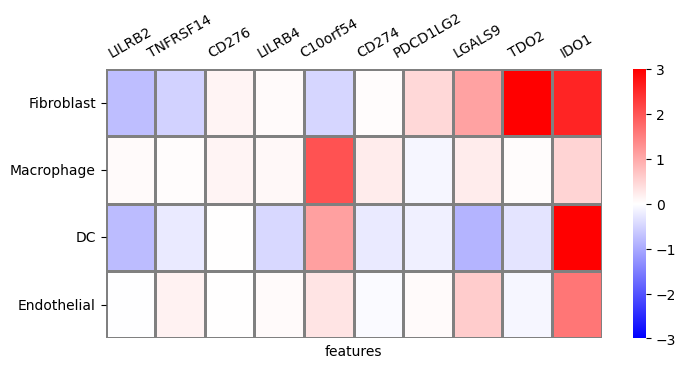

In [5]:
# Plot heatmap for Immune Suppression Genes related to TSK signaler
plt.figure(figsize=(8, 3.5))
sns.heatmap(comparison_df_tsk_signaler.loc[comparison_set_immune_supression].T, cmap='bwr', center=0, vmin=-3.0, vmax=3.0, linewidths=1, linecolor='grey')
plt.yticks(rotation=0)
plt.xticks(fontsize=18, rotation=45)
plt.tick_params(labelbottom=False, bottom=False, top=False, labeltop=True)
plt.xticks(rotation=30)
plt.show()

In [6]:
# Heatmap for Inhibitory Genes related to T-cell receiver
gene_list_inhibitory = inhibitory # Use a specific name for this gene list
comparison_df_tcell_fibro = pd.DataFrame()
comparison_df_tcell_mac = pd.DataFrame()
comparison_df_tcell_dc = pd.DataFrame()
comparison_df_tcell_endo = pd.DataFrame()
comparison_df_tcell_tsk = pd.DataFrame()

for pat in result_df2['patient'].unique():
    fibro_tcell = result_df2[(result_df2['inter'] == 'T-cell_vs_Fibroblast') &
                             (result_df2['patient'] == pat)]['beta']
    mac_tcell = result_df2[(result_df2['inter'] == 'T-cell_vs_Macrophage') &
                           (result_df2['patient'] == pat)]['beta']
    dc_tcell = result_df2[(result_df2['inter'] == 'T-cell_vs_DC') &
                          (result_df2['patient'] == pat)]['beta']
    endo_tcell = result_df2[(result_df2['inter'] == 'T-cell_vs_Endothelial') &
                            (result_df2['patient'] == pat)]['beta']
    tsk_tcell = result_df2[(result_df2['inter'] == 'T-cell_vs_TSK') &
                           (result_df2['patient'] == pat)]['beta']

    comparison_df_tcell_fibro[pat] = fibro_tcell
    comparison_df_tcell_mac[pat] = mac_tcell
    comparison_df_tcell_dc[pat] = dc_tcell
    comparison_df_tcell_endo[pat] = endo_tcell
    comparison_df_tcell_tsk[pat] = tsk_tcell

comparison_df_tcell_receiver = pd.DataFrame(index=comparison_df_tcell_fibro.index,
                                            columns=['Fibroblast', 'Macrophage', 'DC', 'Endothelial', 'TSK'])

In [7]:
# Exclude 'P4' as per original notebook logic
comparison_df_tcell_receiver['Fibroblast'] = comparison_df_tcell_fibro.drop(['P4'], axis=1).median(axis=1)
comparison_df_tcell_receiver['Macrophage'] = comparison_df_tcell_mac.drop(['P4'], axis=1).median(axis=1)
comparison_df_tcell_receiver['DC'] = comparison_df_tcell_dc.drop(['P4'], axis=1).median(axis=1)
comparison_df_tcell_receiver['Endothelial'] = comparison_df_tcell_endo.drop(['P4'], axis=1).median(axis=1)
comparison_df_tcell_receiver['TSK'] = comparison_df_tcell_tsk.drop(['P4'], axis=1).median(axis=1)

comparison_df_tcell_receiver.index = comparison_df_tcell_receiver.index.str.upper()
comparison_df_tcell_receiver = comparison_df_tcell_receiver.rename(index={'C10ORF54': 'C10orf54'}) 

comparison_set_inhibitory = [i.upper() for i in gene_list_inhibitory]
comparison_set_inhibitory = ['C10orf54' if x == 'C10ORF54' else x for x in comparison_set_inhibitory] 


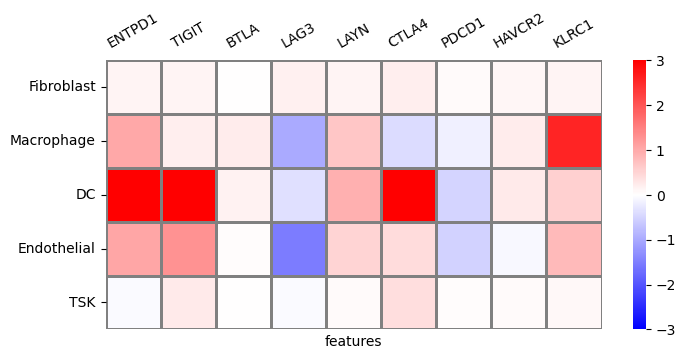

In [8]:
# Plot heatmap for Inhibitory Genes related to T-cell receiver
plt.figure(figsize=(8, 3.5))
sns.heatmap(comparison_df_tcell_receiver.loc[comparison_set_inhibitory].T, cmap='bwr', center=0, vmin=-3.0, vmax=3.0, linewidths=1, linecolor='grey')
plt.yticks(rotation=0)
plt.xticks(fontsize=18, rotation=45)
plt.tick_params(labelbottom=False, bottom=False, top=False, labeltop=True)
plt.xticks(rotation=30)
plt.show()